In [1]:
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer
import pandas as pd
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.model_selection import train_test_split

In [2]:
#read train data and test data
train_data = pd.read_csv("train_data.csv",header=0)
test_data = pd.read_csv("test_data.csv",header=0)

#normalize date
train_date = []
test_date = []
for i in train_data["date"]:
    train_date.append(i-2000)
for j in test_data["date"]:
    test_date.append(i-2000)
train_data["date"] = train_date
test_data["date"] = test_date

#split vlidation data from train data (train:val:test = 6:2:2)
#train data, validation data
X_org_train = train_data[["actor_rating", "director_rating", "genre_rating", "language_rating","region_rating", "writer_rating", "date"]].values
y_org_train = train_data[["movie_rating"]]
original_train_data = np.hstack((X_org_train,y_org_train))
X_train,X_val,y_train,y_val = train_test_split(X_org_train,y_org_train,test_size=0.25,random_state=32)

"""
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
"""

#test data
X_test = test_data[["actor_rating", "director_rating", "genre_rating", "language_rating","region_rating", "writer_rating", "date"]].values
y_test = test_data[["movie_rating"]]

"""
X_test = np.array(X_train)
y_test = np.array(y_train)
"""

'\nX_test = np.array(X_train)\ny_test = np.array(y_train)\n'

In [50]:
class RidgeRegression(BaseEstimator, RegressorMixin):
    """ ridge regression"""

    def __init__(self, l2reg=1):
        if l2reg < 0:
            raise ValueError('Regularization penalty should be at least 0.')
        self.l2reg = l2reg

    def fit(self, X, y=None):
        n, num_ftrs = X.shape
        # convert y to 1-dim array, in case we're given a column vector
        y = y.reshape(-1)
        def ridge_obj(w):
            predictions = np.dot(X,w)
            residual = y - predictions
            empirical_risk = np.sum(residual**2) / n
            l2_norm_squared = np.sum(w**2)
            objective = empirical_risk + self.l2reg * l2_norm_squared
            return objective
        self.ridge_obj_ = ridge_obj

        w_0 = np.zeros(num_ftrs)
        self.w_ = minimize(ridge_obj, w_0).x
        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        return np.dot(X, self.w_)

    def score(self, X, y):
        # Average square error
        try:
            getattr(self, "w_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")
        residuals = self.predict(X) - y
        return np.dot(residuals, residuals)/len(y)


def do_grid_search_ridge(X_train, y_train, X_val, y_val):
    # Now let's use sklearn to help us do hyperparameter tuning
    # GridSearchCv.fit by default splits the data into training and
    # validation itself; we want to use our own splits, so we need to stack our
    # training and validation sets together, and supply an index
    # (validation_fold) to specify which entries are train and which are
    # validation.
    X_train_val = np.vstack((X_train, X_val))
    y_train_val = np.concatenate((y_train, y_val))
    val_fold = [-1]*len(X_train) + [0]*len(X_val) #0 corresponds to validation

    # Now we set up and do the grid search over l2reg. The np.concatenate
    # command illustrates my search for the best hyperparameter. In each line,
    # I'm zooming in to a particular hyperparameter range that showed promise
    # in the previous grid. This approach works reasonably well when
    # performance is convex as a function of the hyperparameter, which it seems
    # to be here.
    
    #To edit
    param_grid = [{'l2reg':np.unique(np.concatenate((10.**np.arange(-13.77,-13.74,0.005),)))}]
    
    

    ridge_regression_estimator = RidgeRegression()
    grid = GridSearchCV(ridge_regression_estimator,
                        param_grid,
                        return_train_score=True,
                        cv = PredefinedSplit(test_fold=val_fold),
                        refit = True,
                        scoring = make_scorer(mean_squared_error,
                              greater_is_better = False))
    grid.fit(X_train_val, y_train_val)

    df = pd.DataFrame(grid.cv_results_)
    # Flip sign of score back, because GridSearchCV likes to maximize,
    # so it flips the sign of the score if "greater_is_better=FALSE"
    df['mean_test_score'] = -df['mean_test_score']
    df['mean_train_score'] = -df['mean_train_score']
    cols_to_keep = ["param_l2reg", "mean_test_score","mean_train_score"]
    df_toshow = df[cols_to_keep].fillna('-')
    df_toshow = df_toshow.sort_values(by=["param_l2reg"])
    return grid, df_toshow

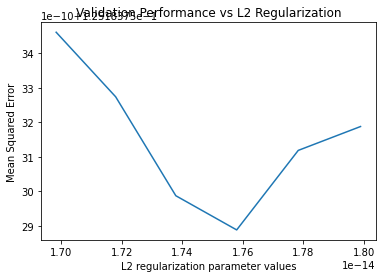

,param_l2reg,mean_test_score,mean_train_score
0,1.698244e-14,0.125184,0.12132
1,1.717908e-14,0.125184,0.12132
2,1.737801e-14,0.125184,0.12132
3,1.757924e-14,0.125184,0.12132
4,1.778279e-14,0.125184,0.12132
5,1.798871e-14,0.125184,0.12132


In [51]:
#Run ridge regression on the provided training dataset.  Choose the λ that minimizes
#the empirical risk (i.e.  the average square loss) on the validation set.
grid,df_toshow=do_grid_search_ridge(X_train, y_train, X_val, y_val)

plt.plot(df_toshow['param_l2reg'],df_toshow['mean_test_score'])
plt.title("Validation Performance vs L2 Regularization")
plt.ylabel('Mean Squared Error')
plt.xlabel('L2 regularization parameter values')
plt.show()

df_toshow

In [53]:
X_test = np.array(X_test)
y_test = np.array(y_test)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [54]:
l2reg = 0
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_pred = ridge_regression_estimator.predict(X_test)
MSE = 0
for i in range(len(y_pred)):
    MSE += (y_pred[i]-y_test[i][0])**2
MSE /= len(y_pred)
print("MSE = {}".format(MSE))
print(y_pred)

MSE = 0.12742931526941273
[8.26454613 8.26374147 7.11820595 8.46523881 2.37746384 9.05081398
 6.03155678 7.02430938 7.10445403 7.01784972 7.46415415 6.53271819
 5.42656352 7.2363452  6.21492684 8.509012   7.50984588 7.12817569
 6.83893367 6.6593868  6.68641884 6.3081123  4.01180293 7.37043821
 7.37164099 8.18604264 7.6344892  7.69185033 7.29218705 7.01373622
 8.00869762 7.28131214 6.7356275  7.54741101 8.16996795 7.11012111
 8.07003101 6.09234367 7.35875957 7.08173917 6.62063428 7.80817592
 5.54905909 6.98438225 6.31021681 6.56659591 8.73129141 6.27593806
 6.50995789 6.3807666  7.49911081 7.52560769 7.35008652 6.69584092
 4.59866691 7.5378657  6.98328517 7.63082229 6.85007101 7.83000912
 7.05111939 6.7814326  6.53924291 6.51224274 6.84043825 6.75210847
 7.74816898 8.22543835 6.29607837 8.2735531  7.65965116 5.65984788
 6.3599132  8.06670021 8.4112939  8.98470418 6.91288023 6.11940463
 7.22800622 4.17731376 8.49754544 6.68819192 7.73263372 7.58204553
 5.81678545 7.10929689 6.77853858 5.

In [56]:
l2reg = 1.758e-14
ridge_regression_estimator = RidgeRegression(l2reg)
ridge_regression_estimator.fit(X_train, y_train)
y_pred = ridge_regression_estimator.predict(X_test)
MSE = 0
for i in range(len(y_pred)):
    MSE += (y_pred[i]-y_test[i][0])**2
MSE /= len(y_pred)
print("MSE = {}".format(MSE))
print(y_pred)

MSE = 0.12742931478903521
[8.26454614 8.26374148 7.11820595 8.46523884 2.37746383 9.05081398
 6.03155677 7.02430937 7.10445403 7.01784972 7.46415415 6.53271819
 5.42656352 7.2363452  6.21492684 8.509012   7.50984588 7.1281757
 6.83893366 6.6593868  6.68641885 6.30811229 4.01180293 7.37043821
 7.37164099 8.18604264 7.6344892  7.69185033 7.29218704 7.01373622
 8.00869762 7.28131213 6.7356275  7.54741102 8.16996795 7.11012112
 8.07003101 6.09234367 7.35875957 7.08173916 6.62063428 7.80817592
 5.54905908 6.98438226 6.31021681 6.56659591 8.73129142 6.27593806
 6.50995789 6.3807666  7.49911082 7.52560769 7.35008651 6.69584092
 4.5986669  7.5378657  6.98328517 7.63082229 6.85007101 7.83000912
 7.05111941 6.7814326  6.53924292 6.51224274 6.84043824 6.75210847
 7.74816898 8.22543835 6.29607837 8.2735531  7.65965115 5.65984787
 6.3599132  8.06670022 8.4112939  8.98470419 6.91288023 6.11940464
 7.22800621 4.17731377 8.49754547 6.68819192 7.73263371 7.58204552
 5.81678544 7.10929689 6.77853859 5.7

In [57]:
y_test = y_test.reshape(-1)
y_test

array([8.1, 8.1, 7.2, 8.1, 3.3, 8.8, 6.2, 6.8, 7.5, 7.3, 7.7, 6.6, 5.5,
       6.9, 6.5, 8.5, 8. , 7.1, 6.4, 7.2, 6.4, 6.3, 5. , 7.1, 7.6, 8.7,
       8. , 7.9, 7.6, 6.8, 8. , 7.4, 6.8, 7.5, 8.2, 6.9, 8.3, 6. , 7.7,
       7.4, 6.7, 8.2, 5.7, 6.8, 5.9, 6.6, 8.9, 6.2, 6.2, 6.2, 7.9, 8.1,
       7.4, 6.7, 4. , 7.7, 6.9, 7.8, 7. , 8.1, 7.7, 6.8, 6.8, 6.5, 6.8,
       6.8, 8.4, 8.2, 6.3, 8.3, 7.7, 6. , 6.4, 8. , 8.7, 8.8, 7.9, 6.1,
       7.3, 5.2, 8.8, 7. , 7.9, 7.8, 6.1, 7.8, 7.3, 5.7, 6.9, 5.4, 8.1,
       6.8, 6.6, 5.5, 8.8, 8.4, 7.7, 7.3, 7.7, 6.5, 7.3, 6.9, 6.5, 7.9,
       5.8, 6.9, 7. , 7.1, 6.4, 8.4, 6.8, 5.6, 6.9, 5.6, 8.5, 7.2, 6.1,
       6.9, 7.5, 5.6, 8.1, 6.4, 4.7, 5. , 6.9, 7.5, 6.1, 8.6, 5.1, 4. ,
       7.6, 8. , 7.3, 6.9, 8.4, 5.2, 7.5, 6.6, 6.3, 8.1, 7.4, 8.1, 7.5,
       8.3, 6.6, 6.9, 6.9, 9. , 6.6, 7.3, 9. , 7.3, 7.6, 7.3, 6.5, 6.4,
       4.1, 7.7, 8.9, 7.8, 7.3, 8.6, 8.3, 6.8, 6.9, 7.1, 4.9, 5.1, 7.4,
       7.8, 7.8, 7.8, 8. , 7.6, 8.6, 5.1, 8. , 6.1, 8.2, 7.9, 8.